## Statistical tests to determine whether differences between two or more groups are real or might be due to minor variation ("noise") in the data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

seg_df = pd.read_csv('data/003_segments.csv')
seg_df.head()

,Segment,age,gender,income,kids,own_home,subscribe
0,travelers,60.794945,male,57014.537526,0,True,False
1,travelers,61.764535,female,43796.941252,0,False,False
2,travelers,47.493356,male,51095.344683,0,True,False
3,travelers,60.963694,male,56457.722237,0,True,True
4,travelers,60.594199,female,103020.070798,0,True,False


## Testing Group Frequencies: chisq.test().

In [2]:
seg_df.Segment.value_counts()

suburb_mix    100
travelers      80
moving_up      70
urban_hip      50
Name: Segment, dtype: int64

In [3]:
stats.chisquare(seg_df.Segment.value_counts())
# p-value < 0.05, can reject null hypothesis (H0: segments are of same size) with 95% confidence.

Power_divergenceResult(statistic=17.333333333333336, pvalue=0.0006034948344733141)

In [4]:
# Is subscription status independent from home ownership (is there a relationship, e.g., own_home True
# has subscription - and own_home False has no subscription).
# This could be difficult to answer with just crosstable.
pd.crosstab(seg_df.subscribe, columns=seg_df.own_home)

own_home,False,True
subscribe,,
False,143,122
True,24,11


In [5]:
# But easier to answer with chi2_contingency.
# H0: subscribe and own_home are unrelated/independent of each other (no evidence that subscribe and own_home are related).
# p-value (0.1459) > 0.05, cannot reject null hypothesis.
stats.chi2_contingency(pd.crosstab(seg_df.subscribe, columns=seg_df.own_home))

(2.114527405072716,
 0.14590708913184341,
 1,
 array([[147.51666667, 117.48333333],
        [ 19.48333333,  15.51666667]]))

In [6]:
# Same but with labels.
sub_by_home = pd.crosstab(seg_df.subscribe, columns=seg_df.own_home)
print('chisq_stat: {0}\np_value: {1}\ndof: {2}\nexpected_values: {3}'
      .format(*stats.chi2_contingency(sub_by_home)))

chisq_stat: 2.114527405072716
p_value: 0.14590708913184341
dof: 1
expected_values: [[147.51666667 117.48333333]
 [ 19.48333333  15.51666667]]


## Testing Group Means: t.test()

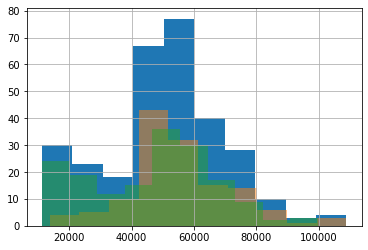

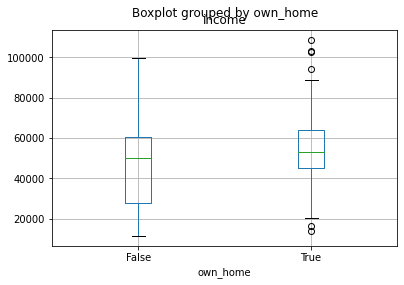

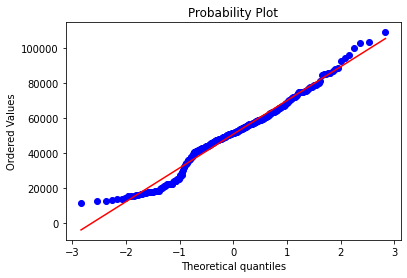

In [8]:
# A t-test compares the mean of one sample against the mean of another sample.
# Many statistical tests assume that the data follow a normal distribution or some other smooth 
# continuous distribution; skewness or outliers violate those assumptions and might lead to an
# inaccurate test. 
# Below, not optimal: 
# - Distributions are skewed, not perfect normal distributions.
# - Income True has outliers.
# - QQ plot: One tail of the income distribution bows away from the line that represents an exact 
# normal distribution, income distribution is skewed.

from scipy import stats
import matplotlib.pyplot as plt

income_own_home = seg_df.income[seg_df.own_home]
income_dont_own_home = seg_df.income[~seg_df.own_home]

seg_df.income.hist() # Not shown.
income_own_home.hist(alpha=0.5) # Not shown.
income_dont_own_home.hist(alpha=0.5) # Not shown.
seg_df.boxplot(column='income', by='own_home') # Not shown.
plt.figure()
_ = stats.probplot(seg_df.income, dist='norm', plot=plt) # Not shown.

In [9]:
income_dont_own_home.mean(), income_dont_own_home.std()

(46892.35166199144, 20335.071080860194)

In [10]:
income_own_home.mean(), income_own_home.std()

(55412.13190716666, 16917.482476619334)

In [11]:
# The t statistic is −3.96, with a p-value of 0.00009. This means that the null
# hypothesis (H0: no difference in income by home ownership) is rejected. The data suggest that
# people who own their homes have higher income.
stats.ttest_ind(income_dont_own_home, income_own_home, equal_var=False) # equal_var: equal population variances.

Ttest_indResult(statistic=-3.960321465078199, pvalue=9.372809221211885e-05)

In [12]:
# Can have 95% conﬁdence that group difference in income is between -11525 to -5514.

count_dont_own_home = income_dont_own_home.shape[0]
count_own_home = income_own_home.shape[0]
dof = count_dont_own_home + count_own_home - 2
geometric_mean_sem = np.sqrt(((count_dont_own_home - 1)
                              * stats.sem(income_dont_own_home)**2
                              + (count_own_home - 1)
                              * stats.sem(income_own_home)**2)/dof)
stats.t.interval(alpha=0.95, # 95% confidence interval.
                 df=dof, # Degrees of freedom = group A sample count + group B sample count - 2.
                 loc=income_dont_own_home.mean()\
                     - income_own_home.mean(), # loc: Difference in means between group A and group B.
                 scale=geometric_mean_sem) # Scale: geometric mean of standard errors for each group.

(-11525.353750453669, -5514.206739896775)

In [13]:
def ttest(a, b):
  # This function displays statistics on two groups, runs a t-test, and finds the 95% confidence 
  # interval of the mean difference between groups. Same as above but reusable.
  
  # Get means and standard deviation of each group.
  mean_a = a.mean() 
  mean_b = b.mean()
  
  std_a = a.std()
  std_b = b.std()
  
  print('Group a - mean: {0}  standard deviation: {1}'
        .format(mean_a, std_a))
  print('Group b - mean: {0}  standard deviation: {1}\n'
        .format(mean_b, std_b))
  
  # Run a Welch's t-test between the groups.
  ttest_out = stats.ttest_ind(a, b, equal_var=False)
  print("Welch's t-test statistic: {0}\np-value: {1}\n"
        .format(ttest_out.statistic, ttest_out.pvalue))
  
  # Find the 95% confidence interval using scipy.statst.interval function. The difference in means
  # is the location of the distribution (loc parameter). The geometric mean of the standard error of
  # each group is the scale.
  count_a = a.shape[0]
  count_b = b.shape[0]
  dof = count_a + count_b - 2
  
  geometric_mean_sem = np.sqrt(((count_a - 1) * stats.sem(a)**2
                                + (count_b -1) * stats.sem(b)**2)/dof)
  print('95% confidence interval of the mean difference between a and'
        ' b:\n{0}'
        .format(stats.t.interval(alpha=0.95, df=dof,
                                 loc=mean_a - mean_b,
                                 scale=geometric_mean_sem)))
  

In [14]:
ttest(income_dont_own_home, income_own_home)

Group a - mean: 46892.35166199144  standard deviation: 20335.071080860194
Group b - mean: 55412.13190716666  standard deviation: 16917.482476619334

Welch's t-test statistic: -3.960321465078199
p-value: 9.372809221211885e-05

95% confidence interval of the mean difference between a and b:
(-11525.353750453669, -5514.206739896775)


In [15]:
# The p-value is 0.92. This means that the null
# hypothesis (H0: no difference in the income of the travelers by home ownership) cannot be rejected.
# The data suggest that travelers who own their homes and who don't have no difference in income.
traveler_subset = seg_df.loc[seg_df.Segment == 'travelers']
ttest(traveler_subset.income[~traveler_subset.own_home],
      traveler_subset.income[traveler_subset.own_home])

Group a - mean: 62923.233941015686  standard deviation: 22233.49397700984
Group b - mean: 62449.90773236651  standard deviation: 19580.36093716456

Welch's t-test statistic: 0.09365502472389607
p-value: 0.925781815932494

95% confidence interval of the mean difference between a and b:
(-6107.120685163211, 7053.77310246156)


## Testing Multiple Group Means: Analysis of Variance (ANOVA)

An analysis of variance (ANOVA) compares the means of multiple groups. More casually, ANOVA tests for difference among multiple means, assuming that the groups have similar variance. An ANOVA can handle single factors (one-way ANOVA), two factors (two-way), and higher orders including interactions among factors.

In [16]:
# f_oneway: One-way ANOVA.
stats.f_oneway(income_dont_own_home, income_own_home)

F_onewayResult(statistic=15.048326580627759, pvalue=0.000129010355414249)

In [17]:
# A more fully featured set of ANOVA methods are found in the Statsmodels package.
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova

In [18]:
# p-value 0.000129 reﬂects that there is signiﬁcant variation in income between those who do and do
# not own their own homes.
income_home_lm = smf.ols('income ~ own_home', data=seg_df).fit()
sms_anova.anova_lm(income_home_lm)

,df,sum_sq,mean_sq,F,PR(>F)
own_home,1.0,5.374074e+09,5.374074e+09,15.048327,0.000129
Residual,298.0,1.064221e+11,3.571210e+08,NaN,NaN


In [19]:
# p-value 2.794439e-49 reﬂects that income varies signiﬁcantly by segment.
income_segment_lm = smf.ols('income ~ Segment', data=seg_df).fit()
sms_anova.anova_lm(income_segment_lm)

,df,sum_sq,mean_sq,F,PR(>F)
Segment,3.0,6.008669e+10,2.002890e+10,114.651236,2.794439e-49
Residual,296.0,5.170946e+10,1.746941e+08,NaN,NaN


In [20]:
# If income varies by both home ownership and segment, does that mean that a more complete model
# should include both? We can add both factors into the ANOVA model to test this.
# The results indicate that when we try to explain income differences in income by both Segment and 
# own_home, segment is a signiﬁcant predictor (p 3.858516e-49) but home ownership is not a signiﬁcant
# predictor (p 0.633). Yet the previous results said that it was signiﬁcant. What’s the difference? 
# What is happening is that segment and home ownership are not independent, and the effect is
# captured sufﬁciently by segment membership alone. Home ownership accounts for little more over and
# above what can be explained by Segment.
income_home_segment_lm = smf.ols('income ~ Segment + own_home',
                                 data=seg_df).fit()
sms_anova.anova_lm(income_home_segment_lm)

,df,sum_sq,mean_sq,F,PR(>F)
Segment,3.0,6.008669e+10,2.002890e+10,114.352374,3.858516e-49
own_home,1.0,4.000708e+07,4.000708e+07,0.228415,6.330554e-01
Residual,295.0,5.166945e+10,1.751507e+08,NaN,NaN


In [22]:
# Could it be that home ownership is related to income in some segments but not in others? This would
# be represented in model by an interaction effect. In a model formula, "+" indicates that variables
# should be modeled for main effects only. We can instead write ":" for an interaction or "∗" for
# both main effect and interaction.
# We test main effects and interaction of home ownership and segment:

# Again, segment is a significant predictor, while home ownership and the interaction of segment with
# home ownership are not signiﬁcant. 
income_home_segment_lm = smf.ols('income ~ Segment * own_home',
                                 data=seg_df).fit()
sms_anova.anova_lm(income_home_segment_lm)

,df,sum_sq,mean_sq,F,PR(>F)
Segment,3.0,6.008669e+10,2.002890e+10,113.502010,9.839888e-49
own_home,1.0,4.000708e+07,4.000708e+07,0.226717,6.343252e-01
Segment:own_home,3.0,1.422781e+08,4.742603e+07,0.268759,8.479014e-01
Residual,292.0,5.152717e+10,1.764629e+08,NaN,NaN


In [23]:
# This tells us that Model 1 — which includes both segment and home ownership — is not significantly
# different in overall fit from Model 0. (H0: no difference between models. Do not rejecto H0,
# p-value 0.633055). 

# But to find a model (for the same data set) with the best overall fit, it is better to compare AIC
# or BIC of different models (y ~ a + b vs y ~ a + c vs y ~ a + b + c ...) with each other. The 
# lower the AIC or BIC, the better the model.
sms_anova.anova_lm(smf.ols('income ~ Segment', data=seg_df).fit(),
                   smf.ols('income ~ Segment + own_home',
                           data=seg_df).fit(),
                   typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,296.0,5.170946e+10,0.0,NaN,NaN,NaN
1,295.0,5.166945e+10,1.0,4.000708e+07,0.228415,0.633055


## Visualize confidence interval for group means

In [24]:
income_segment_lm = smf.ols('income ~ Segment', data=seg_df).fit()
income_segment_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     114.7
Date:                Mon, 30 Aug 2021   Prob (F-statistic):           2.79e-49
Time:                        09:48:04   Log-Likelihood:                -3270.5
No. Observations:                 300   AIC:                             6549.
Df Residuals:                     296   BIC:                             6564.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.176e+04   1579.756     32.767      0.000    4.87e+04    5.49e+04
Segment[T.suburb_mix]  3788.7303   2059.750      1.839      0.067    -264.880    7842.341
Segment[T.travelers]   1.085e+04   2163.170      5.014      0.000    6588.960    1.51e+04
Segment[T.urban_hip]   -3.15e+04   2447.348    -12.869      0.000   -3.63e+04   -2.67e+04
==============================================================================
Omnibus:                       14.628   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.432
Skew:                           0.089   Prob(JB):                     2.02e-08
Kurtosis:                       4.674   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
income_segment_lm.params

Intercept                51763.552666
Segment[T.suburb_mix]     3788.730259
Segment[T.travelers]     10846.102661
Segment[T.urban_hip]    -31495.815349
dtype: float64

In [26]:
# That is strange, how can a negative income be interpreted? It is easier to remove the intercept
# and do the same again so that the confidence interval is easier to interpret.
income_segment_lm.conf_int()

,0,1
Intercept,48654.575215,54872.530118
Segment[T.suburb_mix],-264.880397,7842.340915
Segment[T.travelers],6588.959959,15103.245364
Segment[T.urban_hip],-36312.222507,-26679.408192


In [27]:
# -1 removes the intercept from model.
income_segment_lm_adjusted = smf.ols('income ~ -1 + Segment',
                                     data=seg_df).fit()
income_segment_lm_adjusted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     114.7
Date:                Mon, 30 Aug 2021   Prob (F-statistic):           2.79e-49
Time:                        09:48:05   Log-Likelihood:                -3270.5
No. Observations:                 300   AIC:                             6549.
Df Residuals:                     296   BIC:                             6564.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Segment[moving_up]   5.176e+04   1579.756     32.767      0.000    4.87e+04    5.49e+04
Segment[suburb_mix]  5.555e+04   1321.719     42.030      0.000     5.3e+04    5.82e+04
Segment[travelers]   6.261e+04   1477.727     42.369      0.000    5.97e+04    6.55e+04
Segment[urban_hip]   2.027e+04   1869.193     10.843      0.000    1.66e+04    2.39e+04
==============================================================================
Omnibus:                       14.628   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.432
Skew:                           0.089   Prob(JB):                     2.02e-08
Kurtosis:                       4.674   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
means = income_segment_lm_adjusted.params
means

Segment[moving_up]     51763.552666
Segment[suburb_mix]    55552.282925
Segment[travelers]     62609.655328
Segment[urban_hip]     20267.737317
dtype: float64

In [29]:
ci = income_segment_lm_adjusted.conf_int()
ci

,0,1
Segment[moving_up],48654.575215,54872.530118
Segment[suburb_mix],52951.125768,58153.440082
Segment[travelers],59701.473216,65517.837440
Segment[urban_hip],16589.145587,23946.329046


<AxesSubplot:>

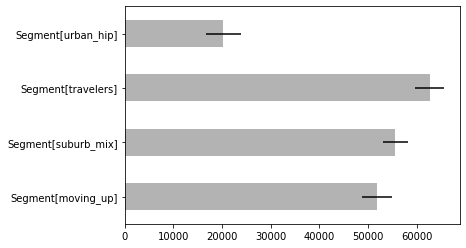

In [30]:
means.plot(kind='barh', xerr=ci[1]-means, color='0.7')

(0.0, 68000.0)

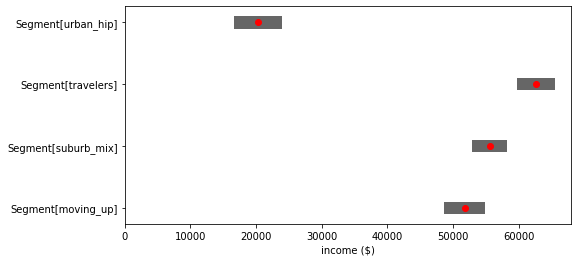

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(y=range(4), left=ci[0], width=ci[1]-ci[0],
         height=0.2, color='0.4')
plt.xlabel('income ($)')
plt.yticks(range(len(means)), ci.index)
plt.plot(means, range(4), 'ro')
plt.xlim((0, 68000))

In [32]:
def plot_confidence_intervals(centers, conf_ints, zero_line=False):
  '''Plot centers and confidence intervals'''
  plt.figure(figsize=(8,4))
  sort_index = np.argsort(centers.values)
  centers = centers[sort_index]
  conf_ints = conf_ints.iloc[sort_index]
  plt.barh(y=range(len(centers)), left=conf_ints[0],
           width=conf_ints[1]-conf_ints[0],
           height=0.2, color='0.4')
  plt.yticks(range(len(centers)), conf_ints.index)
  plt.plot(centers, range(len(centers)), 'ro')
  if zero_line:
    plt.plot([0,0],[-.5, len(centers) - 0.5], 'gray',
             linestyle='dashed')
    plt.xlim((-.05, 1.1 * conf_ints.iloc[:,1].max()))
  plt.ylim((-.5, len(centers) - 0.5))

Text(0.5, 0, 'income')

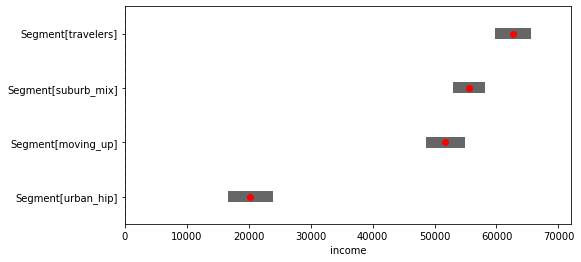

In [33]:
plot_confidence_intervals(means, ci, zero_line=True)
plt.xlabel('income')